In [ ]:
# Jhose Immanuel Sembiring
# 1103202047
# TK44G4
# Modern_NiN

#Library

In [1]:
import torch
from torch import nn, optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

#Mendefinisikan Model NiN

In [2]:
# Definisikan blok NiN yang lebih kecil
def nin_block(in_channels, out_channels, kernel_size, strides, padding):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size, strides, padding), nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, kernel_size=1), nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, kernel_size=1), nn.ReLU())

# Definisikan arsitektur NiN yang lebih kecil
class SmallNiN(nn.Module):
    def __init__(self, num_classes=10):
        super(SmallNiN, self).__init__()
        self.net = nn.Sequential(
            nin_block(1, 16, kernel_size=5, strides=2, padding=2),
            nn.MaxPool2d(2, stride=2),
            nin_block(16, 32, kernel_size=3, strides=1, padding=1),
            nn.MaxPool2d(2, stride=2),
            nn.Dropout(0.5),
            nin_block(32, num_classes, kernel_size=3, strides=1, padding=1),
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten()
        )

    def forward(self, x):
        return self.net(x)

#Memproses Data

In [3]:
# Definisikan transformasi dataset
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

# Load subset dataset FashionMNIST
trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=16, shuffle=True, num_workers=2)

testset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=16, shuffle=False, num_workers=2)


#Inisialisasi Model

In [4]:
# Inisialisasi model, loss function dan optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = SmallNiN(num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

#Pelatihan Model

In [5]:
# Training loop
num_epochs = 2
train_loss_history = []
test_loss_history = []
train_acc_history = []
test_acc_history = []

for epoch in range(num_epochs):
    net.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(trainloader)
    train_acc = 100 * correct / total
    train_loss_history.append(train_loss)
    train_acc_history.append(train_acc)

    net.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_loss /= len(testloader)
    test_acc = 100 * correct / total
    test_loss_history.append(test_loss)
    test_acc_history.append(test_acc)

    print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%')


Epoch [1/2], Train Loss: 1.5818, Train Acc: 47.42%, Test Loss: 1.1814, Test Acc: 61.37%
Epoch [2/2], Train Loss: 1.1766, Train Acc: 61.62%, Test Loss: 1.0949, Test Acc: 63.21%


#Visualisasi Loss dan Akurasi

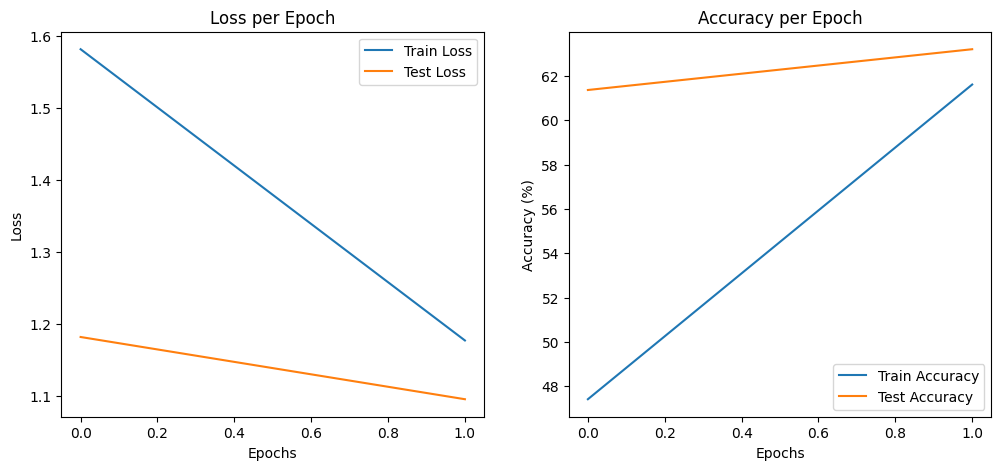

In [6]:
# Plot grafik loss dan akurasi
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_history, label='Train Loss')
plt.plot(test_loss_history, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss per Epoch')

plt.subplot(1, 2, 2)
plt.plot(train_acc_history, label='Train Accuracy')
plt.plot(test_acc_history, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Accuracy per Epoch')

plt.show()